In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Embedding,LSTM,Conv1D,MaxPooling1D
from tensorflow.keras.layers import Reshape,RepeatVector,Permute,Lambda,ActivityRegularization,Masking,Conv1D,Conv3D
from tensorflow.keras.layers import GlobalAveragePooling1D,Input,SeparableConv1D,SeparableConv2D,concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import cv2
from train_i3d import plot_model
from tensorflow.keras.applications import VGG16
from datagenerator import FramesFeatureGenerator
import os
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16

# 设计网络结构

In [ ]:
def create_model_v2():
    vgg_m = VGG16(include_top=False,input_shape=(240,240,3))    
    ipt_vd = Input((40,240,240,3))
    def extend_vd_img(x):
#         print(x.shape)
        tfs = []
        for i in range(x.shape[1]):
            img_tf = x[:,i,:,:]
            tfs.append( img_tf)
        return tfs

    lambda_out = layers.Lambda(extend_vd_img)(ipt_vd)
#     print(len(lambda_out))
    vgg_fs = []
    img_s = []
    for i in lambda_out:
#         print(i.shape)
        vgg_fs.append(vgg_m(i))
        img_s.append(i)
#     out = concatenate(vgg_fs)
    out = [img_s,vgg_fs]
#     out = Reshape((40,7,7,512))(out)
    m = Model(inputs=ipt_vd,outputs=out)
    print('v2 model',m.input_shape,m.output_shape)
    return m
# m1.summary()
# m2 = create_model_v2()


# 测试网络结构输出是否一直

In [100]:
m_v2 = create_model_v2()
# plot_model(m_v1,to_file='model_pic/vgg_test40_frame.png',show_shapes=True,show_dtype=True,)


v2 model (None, 40, 240, 240, 3) [[(None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3)], [(None, 7, 7, 512), (None, 7, 7, 512), (None, 7, 7, 512), (None, 7, 7, 512), (None, 7, 7, 512), (None, 7, 7, 512), (None, 7,

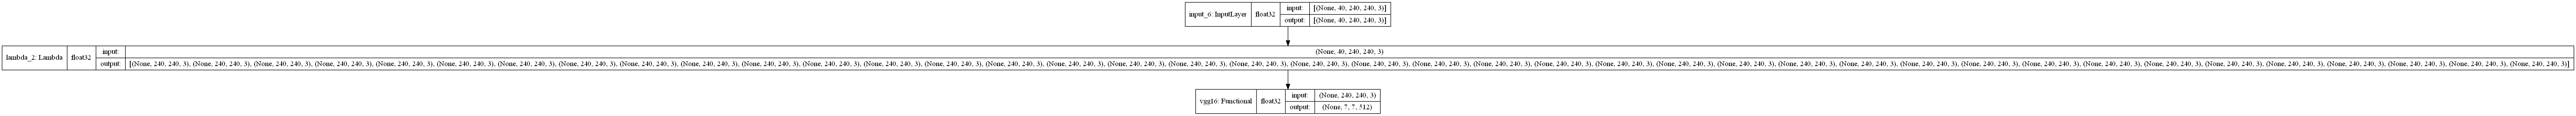

In [101]:
plot_model(m_v2,to_file='model_pic/vgg_test40_frame-v2.png',show_shapes=True,show_dtype=True,)

In [106]:
n = 4
x_bath = np.random.randint(0,10,size=(n,40,240,240,3))
    
x_bath.astype(np.uint8).shape


(4, 40, 240, 240, 3)

## 检查模型预测稳定性，ok

In [107]:
[x_pred2_a,vgg_f_a] = m_v2.predict(x_bath)
[x_pred2_b,vgg_f_b] = m_v2.predict(x_bath)

In [108]:
for i in range(len(x_pred2_a)):
#     print(x_pred2_a[i].shape)
    t1 = x_pred2_a[i]
    t2 = x_pred2_b[i]    
    print(np.unique(t1==t2).flatten())

[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


In [109]:
for i in range(len(vgg_f_a)):
#     print(x_pred2_a[i].shape)
    t1 = vgg_f_a[i]
    t2 = vgg_f_b[i]    
    print(np.unique(t1==t2).flatten())

[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


## 检查模型集成vgg抽取特征和直接预测特征的差异

In [124]:
len(x_pred2),len(vgg_f),x_pred2[0].shape,vgg_f[0].shape

(40, 40, (4, 240, 240, 3), (4, 7, 7, 512))

In [125]:
[x_pred2,vgg_f] = m_v2.predict(x_bath)


In [126]:
rs_vggs=[]
rs2s=[]
i_s=[]
j_s=[]
diff_rs=[]
for i in range(40):
    print(i,x_pred2[i].shape)
    for j in range(n):
        pred_img2 = x_pred2[i][j]
        vgg_pred_f = vgg_f[i][j]
        x_batch_img = x_bath[j][i]
        vgg_each_f = vgg_m.predict(x_batch_img.reshape(1,240,240,3))
        vgg_each_f = vgg_each_f.reshape(7,7,512)
        rs_vgg_f_diff = vgg_each_f==vgg_pred_f
        rs2 = pred_img2==x_batch_img   
        rs2 = np.unique(rs2.flatten())
        diff_rs = np.append(diff_rs,(vgg_each_f-vgg_pred_f).flatten(),)
        print('rs2',rs2)   
        i_s.append(i)
        j_s.append(j)
        rs2s.append(str(rs2))    
        rs_vggs.append(str(rs_vgg))    
    

0 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
1 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
2 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
3 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
4 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
5 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
6 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
7 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
8 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
9 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
10 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
11 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
12 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
13 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs2 [ True]
14 (4, 240, 240, 3)
rs2 [ True]
rs2 [ True]
rs2 [ True]
rs

In [127]:
len(diff_rs)

4014080

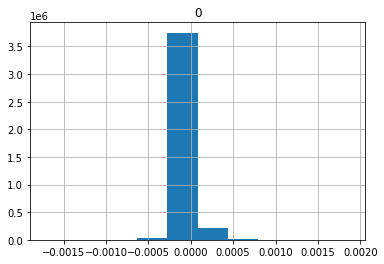

,0
count,4.014080e+06
mean,4.348475e-06
std,7.729507e-05
min,-1.716137e-03
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.876116e-03


In [128]:
diff_df = pd.DataFrame(diff_rs)
diff_df.hist()
plt.show()
diff_df.describe()


In [129]:
vgg_each_f.shape

(7, 7, 512)

In [130]:
vgg_pred_f.shape

(7, 7, 512)

In [131]:
(vgg_pred_f==vgg_each_f)[:,:,-2][:,:]

array([[False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False]])

In [132]:
vgg_pred_f[:,:,-2][:,:]

array([[1.1732907 , 0.51959336, 0.29866403, 0.66788906, 0.72829473,
        0.39934355, 0.9865328 ],
       [0.5030091 , 0.12914991, 0.3862031 , 0.360134  , 0.10838151,
        0.12589097, 0.16076493],
       [0.64989245, 0.4589196 , 0.6714321 , 0.6102486 , 0.41651338,
        0.39382154, 0.44823724],
       [0.29532576, 0.32693434, 0.67194986, 0.6541453 , 0.4570186 ,
        0.25208768, 0.2806097 ],
       [0.5388078 , 0.07917899, 0.51775694, 0.56948924, 0.53779286,
        0.31346166, 0.23685652],
       [0.6903891 , 0.19554466, 0.30397865, 0.5462558 , 0.682272  ,
        0.64193547, 0.10552329],
       [0.7593018 , 0.17908916, 0.33442417, 0.6251632 , 0.8277464 ,
        0.79354095, 0.4290845 ]], dtype=float32)

In [133]:
vgg_each_f[:,:,-2][:,:]

array([[1.1733282 , 0.5197917 , 0.29865402, 0.66790354, 0.7283729 ,
        0.39931104, 0.9864836 ],
       [0.5030126 , 0.12907231, 0.3862542 , 0.36014965, 0.10842496,
        0.12586707, 0.16082829],
       [0.6498965 , 0.4589649 , 0.6715003 , 0.6103373 , 0.41646966,
        0.39384377, 0.4483713 ],
       [0.29526523, 0.32692996, 0.6718738 , 0.6541825 , 0.45697567,
        0.25210673, 0.28081796],
       [0.5390144 , 0.07917863, 0.5177145 , 0.5694535 , 0.5377408 ,
        0.3134451 , 0.23690623],
       [0.69063926, 0.19556352, 0.30396774, 0.54624784, 0.6821625 ,
        0.64177305, 0.10547298],
       [0.7590968 , 0.1787923 , 0.334305  , 0.6251142 , 0.82753074,
        0.7931931 , 0.4289576 ]], dtype=float32)

In [134]:
rs_a = pd.DataFrame({'i':i_s,'j':j_s,'rs2':rs2s,'rs_vggs':rs_vggs})

In [135]:
rs_a.rs2.value_counts()

[ True]    160
Name: rs2, dtype: int64

In [136]:
rs_a

,i,j,rs2,rs_vggs
0,0,0,[ True],True 21269\nFalse 3819\ndtype: int64
1,0,1,[ True],True 21269\nFalse 3819\ndtype: int64
2,0,2,[ True],True 21269\nFalse 3819\ndtype: int64
3,0,3,[ True],True 21269\nFalse 3819\ndtype: int64
4,1,0,[ True],True 21269\nFalse 3819\ndtype: int64
...,...,...,...,...
155,38,3,[ True],True 21269\nFalse 3819\ndtype: int64
156,39,0,[ True],True 21269\nFalse 3819\ndtype: int64
157,39,1,[ True],True 21269\nFalse 3819\ndtype: int64
158,39,2,[ True],True 21269\nFalse 3819\ndtype: int64


In [122]:
3819/(3819+21266)

0.15224237592186565